In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

In [2]:
data = pd.ExcelFile(r"data/NeuronConnect.xls") # use r before absolute file path 
data = data.parse(0)
data = data.rename(columns={'Neuron 1':'N1', 'Neuron 2':'N2','Nbr':'n_synapse', 'Type':'type'})
data = data[data['type'] != 'NMJ']
data = data[data['type'] != 'EJ']
data = data.drop(1870) # row with disconnected neurons 'avfl' and 'avfr' 
#data = data[data['n_synapse'] > 4 ]

In [3]:
data
#print(data[data['N1'] == 'avfl'])
#print(data[data['N2'] == 'avfr'])

,N1,N2,type,n_synapse
5,ADEL,ADAL,Sp,1
6,ADFL,ADAL,Sp,1
7,AIAL,ADAL,Sp,1
8,AIBL,ADAL,R,1
9,AIBR,ADAL,Rp,2
...,...,...,...,...
6258,PVCL,VD13,Rp,1
6259,PVCR,VD13,R,1
6260,RID,VD13,S,1
6261,VA12,VD13,Rp,1


In [4]:
location_data = pd.ExcelFile(r"data/NeuronType.xls") # use r before absolute file path 
location_data = location_data.parse(0)
location_data = location_data.rename(columns={'Neuron':'neuron', 'Soma Position':'position'})
location_data = location_data[['neuron', 'position']]
location_dict = dict(location_data.to_numpy())

In [5]:
neuron_names = list(data['N1']) + list(data['N2']) 
neuron_names = set(neuron_names)
neuron_names_dict = {name : idx for idx, name in enumerate(neuron_names)}
n_neurons = len(neuron_names)
print(n_neurons)

279


In [6]:
for neuron in neuron_names:
    if neuron not in set(location_dict):
        print(neuron)

In [7]:
# create a graph where all the edges in the dataset are included, except NMJ connections
G = nx.DiGraph()
G.add_nodes_from(range(n_neurons))

In [8]:
node_positions = {neuron_names_dict[neuron] : {'position' : location_dict[neuron]} for neuron in neuron_names}

In [9]:
nx.set_node_attributes(G, node_positions)

In [10]:
G.nodes[1]

{'position': 0.19}

In [11]:
neuron1 = data['N1'].to_numpy()
neuron2 = data['N2'].to_numpy()
synapse_type = data['type'].to_numpy()

for i in range(data.shape[0]):
    if synapse_type[i] == 'S' or synapse_type[i] == 'Sp':
        presynaptic = neuron1[i]
        postsynaptic = neuron2[i]
    if synapse_type[i] == 'R' or synapse_type[i] == 'Rp':
        presynaptic = neuron2[i]
        postsynaptic = neuron1[i]
    
    G.add_edge(neuron_names_dict[presynaptic], neuron_names_dict[postsynaptic]) 

num edges: 2194 num nodes: 279


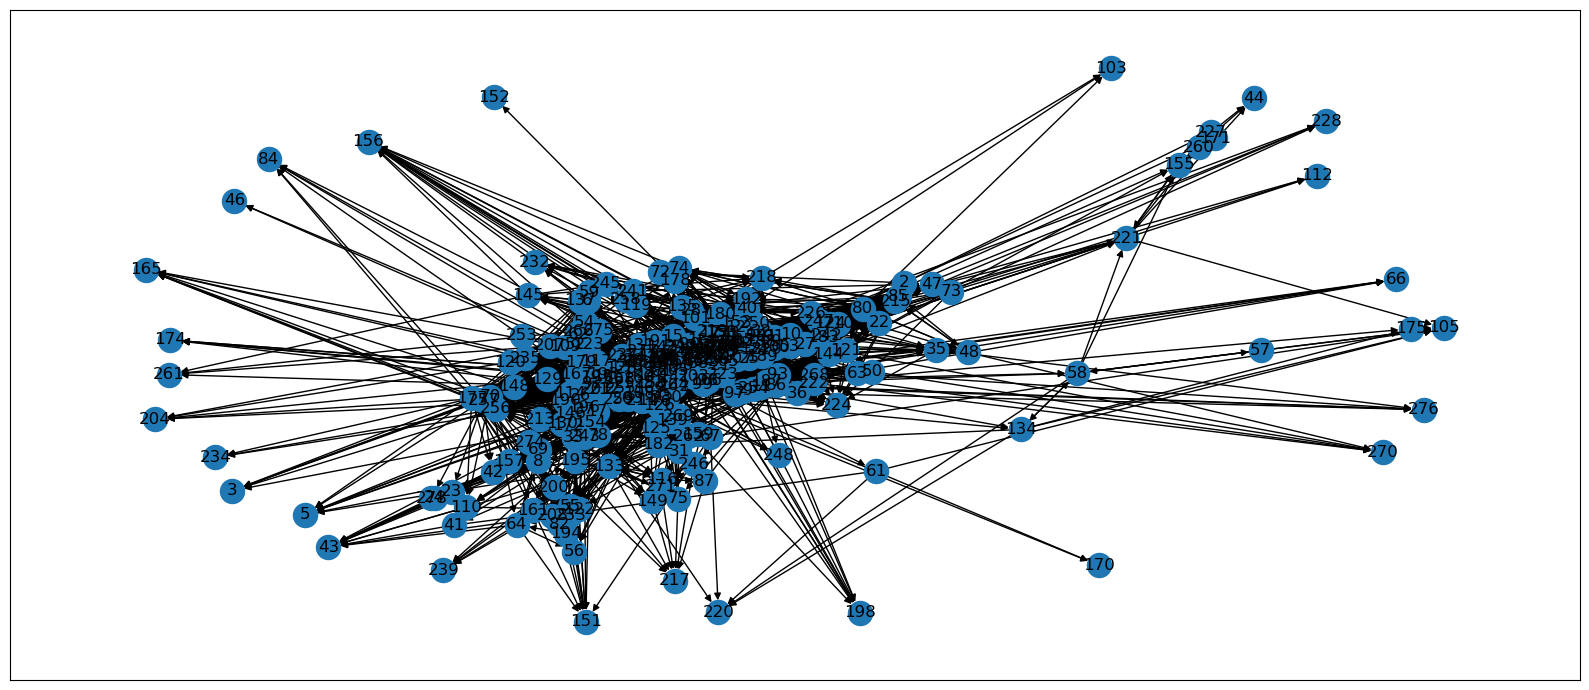

In [12]:
print(
'num edges:', G.number_of_edges(),
'num nodes:', G.number_of_nodes()
)

# visualisation of one of the networks generated
plt.figure(figsize=(16, 7))
#color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, with_labels=True) #, node_color=color_map
#ax[0].set_title("Network graph")

#W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
#sns.heatmap(W0, ax=ax[1], annot=False)
#ax[1].set_title("Adjacency matrix")
#ax[1].set_xlabel("Neuron")
#ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

In [13]:
n_edges = G.number_of_edges()

c_elegans_dataset = from_networkx(G)
c_elegans_dataset['W0'] = torch.zeros(n_edges)
n_inhibitory = n_edges // 2
n_excitatory = n_edges - n_inhibitory

c_elegans_dataset.W0[:n_excitatory] = 1.5
c_elegans_dataset.W0[n_excitatory:] = -3
example_network = c_elegans_dataset

print(example_network.W0.shape)
print(example_network.edge_index.shape)
print(example_network.num_nodes)
example_network

torch.Size([2194])
torch.Size([2, 2194])
279


Data(edge_index=[2, 2194], position=[279], num_nodes=279, W0=[2194])

In [272]:
torch.save(c_elegans_dataset, 'data/c_elegans_data.pt')